# Rapport Projet :

## Présentation du projet : 
Nous sommes trois sportifs et nous avions à cœur de lier notre projet de programmation avec le monde du sport. 
Pour explorer tous les enseignements du cours, nous avons cherché un sport dans lequel la prédiction statistique 
aurait pu répondre à des questions pratiques pour les joueurs et les entraîneurs. 
Comme deux d'entre nous pratiquent le handball, nous nous sommes donnés comme objectif d'élaborer un modèle de prédiction 
du poste d'un joueur de handball en fonction de ses caractéristiques morphologiques. 

Précisons ici que le handball se joue avec 1 gardien et 6 joueurs de champ, répartis en 4 postes :
Pivot, Ailiers (gauche et droit), Arrières (gauche et droit) et Demi-centre.  

![Composition Hand Star Game 2015 ](Images/Compo_France.jpg.webp)

In [ ]:
## Installations requises

! pip install bs4
! pip install selenium
! pip install webdriver-manager
! pip install seaborn
! pip install plotly
! pip install scikit-learn
! pip install nbformat


## Récupération des données
Pour mener à bien ce projet nous avons utilisé des données issues du site de la LNH (Ligue Nationale de Handball). La récupération de ces données a été faite par scrapping. 
Les données disponibles sur le site concernent les joueurs de la LNH inscrit dans un club de la ligue pour la saison 2023/2024. 
Parmi les informations auxquelles nous avons accédé, deux mesures nous intéressent particulièrement, le poids et la taille du joueur, ainsi que l'information sur le poste du joueur.

In [9]:
## Récupération des données

from Scrapping_donnees_fonction import *

#Scrapping(nom_df_match="DF_match_rapport.csv",nom_df_physique="DF_joueur_rapport.csv")

DF_match_rapport = pd.read_csv("Donnees/Donnees_match.csv",index_col=0)
DF_joueur_rapport = pd.read_csv("Donnees/Donnees_physique_joueurs.csv",index_col=0)

In [ ]:
DF_match_rapport.head(10)

In [ ]:
DF_joueur_rapport.head(10)

In [12]:
## Nettoyage du DataFrame avec les données physiques des joueurs

from Nettoyage import *

DF_joueur_rapport = pd.read_csv("Donnees/Donnees_physique_joueurs.csv",index_col=0)

cleaning(DF_joueur_rapport,nom_fichier="DF_joueur_rapport_nettoye.csv")

DF_joueur_rapport_nettoye = pd.read_csv("DF_joueur_rapport_nettoye.csv",index_col=0)


In [13]:
DF_joueur_rapport_nettoye.head(10)

,Poste,Nationalité,Date de naissance,Âge,Taille,Poids,Club actuel,Dernière saison,Poste simplifié,IMC
Kamil Syprzak,Pivot,Pologne,27/07/1991,33.0,207.0,117.0,Paris,NaN,Pivot,27.209302
Tom Pelayo,Arrière Droit,France,23/02/1997,27.0,189.0,95.0,Dunkerque,NaN,Arrière,26.388889
Gabriel Loesch,Ailier Droit,France,12/07/1995,29.0,182.0,73.0,Aix,NaN,Ailier,22.121212
Chema Marquez,Demi Centre,Espagne,20/12/1996,27.0,187.0,94.0,Saint-Raphaël,NaN,Demi Centre,26.857143
Nemanja Ilic,Ailier Gauche,Serbie,11/05/1990,34.0,177.0,76.0,Toulouse,NaN,Ailier,24.516129
Benjamin Richert,Ailier Droit,France,18/04/1998,26.0,187.0,76.0,Chambéry,NaN,Ailier,21.714286
Valero Rivera,Ailier Gauche,Espagne,22/02/1985,39.0,186.0,83.0,Nantes,NaN,Ailier,23.714286
Ian Tarrafeta,Demi Centre,Espagne,04/01/1999,25.0,188.0,88.0,Aix,NaN,Demi Centre,25.142857
Elohim Prandi,Arrière Gauche,France,24/08/1998,26.0,193.0,101.0,Paris,NaN,Arrière,27.297297
Mario Lopez Alvarez,Ailier Droit,Espagne,19/09/1994,30.0,178.0,81.0,Créteil,NaN,Ailier,25.312500



| Page d'un joueur | Page des statistiques de match LNH              |
|-----------------------|-----------------------|
| ![Page d'un joueur](./Images/Screenshot_page_joueur_LNH.png) | ![Page des statistiques de match LNH](./Images/Screenshot_page_match_LNH.png)|

## Statistiques descriptives
A l'issu d'un travail de nettoyage et de présentation des données recueillies, une analyse descriptive s'est imposée pour comprendre la structure des données et s'assurer de l'intérêt de notre intuition initiale. 
Il apparaît en effet que les morphologies des joueurs sont plus proches les unes des autres que ce que nous estimions. Notre pratique du handball amateur permet à des physiques plus petits et plus légers d'avoir une place dans les équipes amateurs. Cependant, le niveau professionnel permet une sélection plus forte sur les physiques et ne sélectionne dans les équipes que des joueurs particulièrement athlétiques.
La disparité que nous présumions entre les postes n'est donc pas aussi marquée. Néanmoins une première projection du nuage des joueurs selon le poids et la taille permet d'identifier certains groupes. 

In [ ]:
## Statistiques descriptives des données morphologiques

from Stat_desc import *

# Représentation des joueurs sur le plan Taille, Poids
Visualisation_Taille_Poids(DF_joueur_rapport_nettoye)

"""
# Nuage de points avec toutes les infos
scatter_plot(DF_joueur_rapport_nettoye,"Taille","Poids", ["Nom", "Âge", "IMC"])
"""

In [ ]:
# Boite à moustache du poids selon le poste
Boxplot_poids(DF_joueur_rapport_nettoye)
afficher_violinplot(DF_joueur_rapport_nettoye,y='Poids')

# Boite à moustache de la taille selon le poste
Boxplot_taille(DF_joueur_rapport_nettoye)
afficher_violinplot(DF_joueur_rapport_nettoye,y='Taille')

In [16]:
#Calcul moyenne et variance du poids et de la taille selon le poste
print(Moyenne_et_Std(DF_joueur_rapport_nettoye))

             Taille Moyenne  Taille Std  Poids Moyenne  Poids Std
Pivot            195.189655    6.408484     102.086207  10.136411
Arrière          193.623853    4.415438      92.834862   8.059402
Ailier           184.000000    4.994502      80.021739   6.456921
Demi Centre      186.584906    5.365251      85.660377   8.180520


Plusieurs choses sont à remarquer sur ces graphiques de distribution.

Les pivots se démarquent notamment par le poids mais c'est aussi le poste avec les plus grandes variances. On peut donc estimer que le poste sera correctement prédit pour les joueurs dans la moyenne des pivots, mais la présence de certaines valeurs marginales limitera sûrement la précision. 

À l'inverse, les demi-centres semblent plus difficiles à prédire. Ceux-ci sont physiquement entre les ailiers et arrières et ont de plus une variance assez forte. Les diagrammes en violon permettent bien de représenter la disparité des physiques de demi-centre. 

Les ailiers se distinguent par une poids médian inférieur aux autres postes et un variance assez faible sur la taille. 

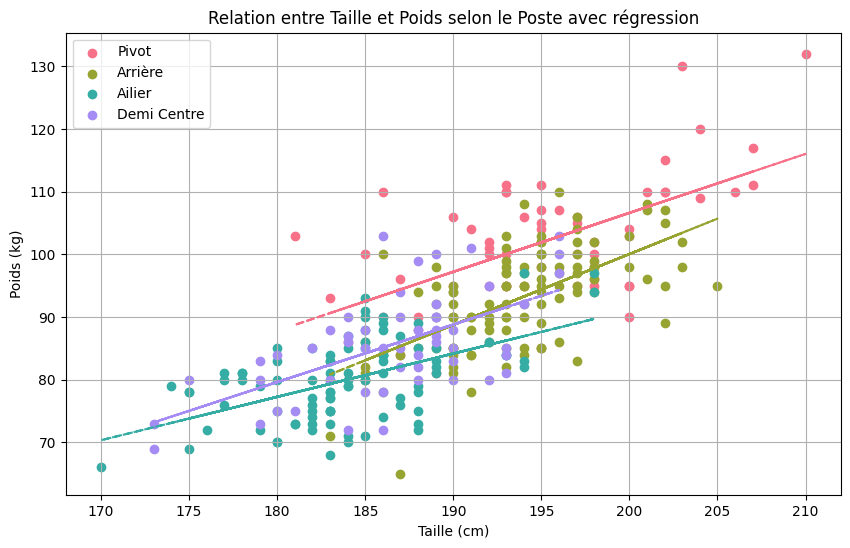

In [17]:

# Nuage de points avec droites de régression linéaire
afficher_regression_par_poste(DF_joueur_rapport_nettoye)

On peut enfin reprendre le nuage de point et y ajouter les droites de régression linéaire pour mettre en évidence les tendances physiques selon les différents postes.
Les coefficients directeurs des droites semblent assez proches, excepté les ailiers pour lesquels la taille est moins corrélée au poids. Cette remarque est cohérente avec les objectifs du poste d'ailier : un grande explosivité, de la rapidité et de la mobilité sont indispensables pour ce poste qui intervient le plus souvent à la fin des actions de jeu.

## Choix de modèle

Pour la partie prédictive de notre projet, nous avons rapidement constaté que l'enjeu était celui d'une catégorisation des individus  Il s’agit d’un problème de classification supervisée. Pour répondre à cet enjeu, nous avons testé trois modèles de classification : KNN, SVM, et Random Forest.

##### K-Nearest Neighbors (KNN)
Le KNN classe un joueur selon leur proximité dans l’espace taille-poids. Ce modèle est intuitif et non-paramétrique, mais se révèle sensible à la distribution des données. 
##### Le Support Vector Machine (SVM)
Le SVM repose sur la séparation des groupes à l’aide d’un hyperplan optimal qui maximise la marge entre les classes, ce qui le rend particulièrement adapté aux données bien séparées et pouvant nécessiter des transformations non linéaires grâce à des noyaux. 
##### Le Random Forest
Le Random Forest fonctionne grace à un grand nombre d’arbres de décision et permet une classification robuste en combinant plusieurs  paramètres. Ce modèle est performant sur des données déséquilibrées ce qui le rend particulièrement efficace pour notre problème puisque certains postes sont doublés (Arrière et Ailier).

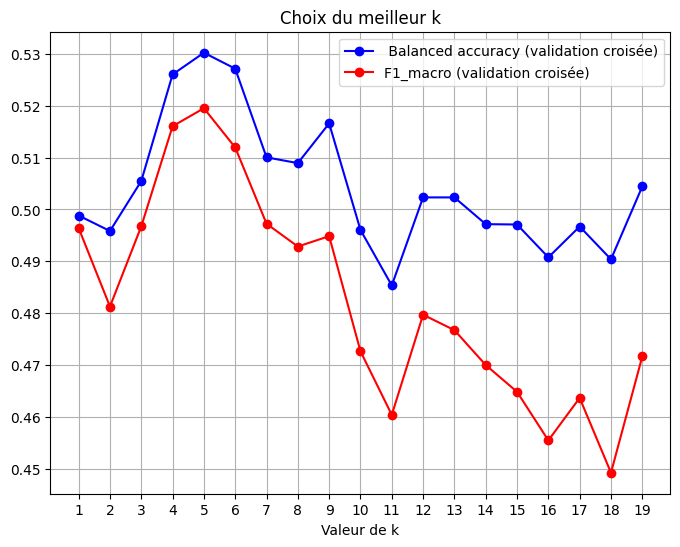

In [18]:
## Choix des paramètres pour les modèles

from Choix_modele import *

parametre_KNN(DF_joueur_rapport_nettoye)

In [19]:
print('Meilleurs paramètres pour SVM :')
parametres_SVM(DF_joueur_rapport_nettoye,metrique='f1_macro')

Meilleurs paramètres pour SVM :
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .................................C=0.1, gamma=scale; total time=   0.0s
[CV] END .................................C=0.1, gamma=scale; total time=   0.0s
[CV] END .................................C=0.1, gamma=scale; total time=   0.0s
[CV] END .................................C=0.1, gamma=scale; total time=   0.0s
[CV] END .................................C=0.1, gamma=scale; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ......

{'C': 1, 'gamma': 10}

In [20]:
print('Meilleurs paramètres pour Random Forest :')
parametres_Random_Forest(DF_joueur_rapport_nettoye,metrique='f1_macro')

Meilleurs paramètres pour Random Forest :
Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 50}

BlaBla sur l'évaluation des modèles (parler de la métrique d'évaluation entre autres)

In [ ]:
## Evaluation des performances des différents modèles

from Evaluation import *

# Modèle KNN :
best_k = 5
Eval_modele_KNN(DF_joueur_rapport_nettoye,best_k)

# Modèle SVM :
best_parametres_SVM = {'kernel': 'rbf','C': 1, 'gamma': 10}
Eval_modele_SVM(DF_joueur_rapport_nettoye,best_parametres_SVM)

# Modèle Random Forest :
best_parametres_RF = {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Eval_modele_Random_Forest(DF_joueur_rapport_nettoye,best_parametres_RF)

In [ ]:
## Prédiction sur l'ensemble du DataSet

from Prediction import *


Prediction(DF_joueur_rapport_nettoye,type_modele='SVC',telechargement='DF_joueur_rapport_predit.csv')

DF_joueur_rapport_predit = pd.read_csv("DF_joueur_rapport_predit.csv",index_col=0)

DF_joueur_rapport_predit.head(10)

BlaBla sur le dataframe des matchs + jointure des 2 dataframes + indicateur de performance

In [24]:
## Nettoyage du DataFrame contenant les données de match

from fusion_csv import *

# Ligne à enlever lorsqu'on lancera le tout
DF_match_rapport = pd.read_csv("Donnees/Donnees_match.csv",index_col=0)

# Nettoyage
traitement(DF_match_rapport,nom_fichier="DF_match_rapport_nettoye.csv")

DF_match_rapport_nettoye = pd.read_csv("DF_match_rapport_nettoye.csv",index_col=0)
# /!\ ajouter la fonction qui crée l'indicateur de performance dans la fonction de traitement

DF_match_rapport_nettoye.head(10)

,Total buts,Total tirs,totalbuts,%total,totalbuts / mj,Buts dans le jeu,Tirs dans le jeu,butstirs,%tirs,tirsbuts / mj,Penalty réussis,Tirs de Penalty,butspenalty,%penalty,penaltybuts / mj,mj,Score LNH *,Temps jeu,Nom formate
SYPRZAK Kamil,220,267,220 / 267,"82,40 %","7,59",131,161,131 / 161,"81,37 %","4,52",89,106,89 / 106,"83,96 %","3,07",29,413.9,08:01:40,Kamil Syprzak
PELAYO Tom,216,294,216 / 294,"73,47 %","7,20",134,190,134 / 190,"70,53 %","4,47",82,104,82 / 104,"78,85 %","2,73",30,470.3,21:16:38,Tom Pelayo
LOESCH Gabriel,191,248,191 / 248,"77,02 %","6,37",107,148,107 / 148,"72,30 %","3,57",84,100,84 / 100,"84,00 %","2,80",30,364.5,27:10:37,Gabriel Loesch
MARQUEZ Chema,189,312,189 / 312,"60,58 %","6,30",178,293,178 / 293,"60,75 %","5,93",11,19,11 / 19,"57,89 %","0,37",30,424.5,17:04:57,Chema Marquez
ILIC Nemanja,183,238,183 / 238,"76,89 %","6,54",116,152,116 / 152,"76,32 %","4,14",67,86,67 / 86,"77,91 %","2,39",28,366.8,21:19:16,Nemanja Ilic
RICHERT Benjamin,170,257,170 / 257,"66,15 %","6,07",84,142,84 / 142,"59,15 %","3,00",86,115,86 / 115,"74,78 %","3,07",28,312.6,15:54:21,Benjamin Richert
RIVERA Valero,169,220,169 / 220,"76,82 %","5,63",89,123,89 / 123,"72,36 %","2,97",80,97,80 / 97,"82,47 %","2,67",30,329.1,18:08:32,Valero Rivera
TARRAFETA Ian,165,246,165 / 246,"67,07 %","6,88",165,246,165 / 246,"67,07 %","6,88",0,0,0 / 0,"0,00 %","0,00",24,443.9,18:39:14,Ian Tarrafeta
PRANDI Elohim,160,248,160 / 248,"64,52 %","5,71",160,248,160 / 248,"64,52 %","5,71",0,0,0 / 0,"0,00 %","0,00",28,373.1,16:34:51,Elohim Prandi
LOPEZ ALVAREZ Mario,159,229,159 / 229,"69,43 %","5,30",95,144,95 / 144,"65,97 %","3,17",64,85,64 / 85,"75,29 %","2,13",30,334.0,21:46:21,Mario Lopez Alvarez


In [6]:
# Jointure des 2 DataFrames

from fusion_csv import *

DF_joint_rapport = jointure_df(DF_joueur_rapport_predit,DF_match_rapport_nettoye,telechargement="DF_joint_rapport.csv")

DF_joint_rapport.head(10)

,Poste,Nationalité,Date de naissance,Âge,Taille,Poids,Club actuel,Dernière saison,Poste simplifié,IMC,...,%tirs,tirsbuts / mj,Penalty réussis,Tirs de Penalty,butspenalty,%penalty,penaltybuts / mj,mj,Score LNH *,Temps jeu
Nom formate,,,,,,,,,,,,,,,,,,,,,
Kamil Syprzak,Pivot,Pologne,27/07/1991,33.0,207.0,117.0,Paris,NaN,Pivot,27.305188,...,"81,37 %","4,52",89,106,89 / 106,"83,96 %","3,07",29,413.9,08:01:40
Tom Pelayo,Arrière Droit,France,23/02/1997,27.0,189.0,95.0,Dunkerque,NaN,Arrière,26.595000,...,"70,53 %","4,47",82,104,82 / 104,"78,85 %","2,73",30,470.3,21:16:38
Gabriel Loesch,Ailier Droit,France,12/07/1995,29.0,182.0,73.0,Aix,NaN,Ailier,22.038401,...,"72,30 %","3,57",84,100,84 / 100,"84,00 %","2,80",30,364.5,27:10:37
Chema Marquez,Demi Centre,Espagne,20/12/1996,27.0,187.0,94.0,Saint-Raphaël,NaN,Demi Centre,26.880952,...,"60,75 %","5,93",11,19,11 / 19,"57,89 %","0,37",30,424.5,17:04:57
Nemanja Ilic,Ailier Gauche,Serbie,11/05/1990,34.0,177.0,76.0,Toulouse,NaN,Ailier,24.258674,...,"76,32 %","4,14",67,86,67 / 86,"77,91 %","2,39",28,366.8,21:19:16
Benjamin Richert,Ailier Droit,France,18/04/1998,26.0,187.0,76.0,Chambéry,NaN,Ailier,21.733535,...,"59,15 %","3,00",86,115,86 / 115,"74,78 %","3,07",28,312.6,15:54:21
Valero Rivera,Ailier Gauche,Espagne,22/02/1985,39.0,186.0,83.0,Nantes,NaN,Ailier,23.991213,...,"72,36 %","2,97",80,97,80 / 97,"82,47 %","2,67",30,329.1,18:08:32
Ian Tarrafeta,Demi Centre,Espagne,04/01/1999,25.0,188.0,88.0,Aix,NaN,Demi Centre,24.898144,...,"67,07 %","6,88",0,0,0 / 0,"0,00 %","0,00",24,443.9,18:39:14
Elohim Prandi,Arrière Gauche,France,24/08/1998,26.0,193.0,101.0,Paris,NaN,Arrière,27.114822,...,"64,52 %","5,71",0,0,0 / 0,"0,00 %","0,00",28,373.1,16:34:51


## Comparaison performance selon le poste prédit

Pour prolonger notre analyse et chercher à interpréter les erreurs de prédiction des modèles, nous cherchons à comparer les performances de joueurs avec les performances moyennes de leur poste réel et du poste auquel nous les avons prédits.

L'objectif est de savoir si un joueur n'a pas été correctement prédit par les modèles mais que son poste de jeu réel ne correspond pas à ces caractéristiques physiques. 

##### Choix de l'indicateur
Pour cela, nous formons un indicateur agrégé de performance qui combine différentes mesures données par la table des performances de match. Un premier indicateur que nous avons tenté est celui d'une rapport simple entre le nombre de buts inscrits multiplié par l'efficacité au tir et divisé par le temps de jeu. Cet indicateur reflète bien la capacité d'un joueur a exploité les situations de but par rapport au temps qu'il passe sur le terrain. 

À l'aide de cet indicateur, nous étudions le ratio entre le score obtenu par le joueur et la moyenne du score pour les autres joueurs de son poste d'origine ainsi que pour son poste prédit. 
Si son score est proche de la moyenne de son poste prédit, on peut estimer que les caractérisques physiques du joueurs correspondent légitimement à un autre poste que celui auquel il évolue actuellement.

In [7]:
## Comparaison des performances

from Comparaison_perf import *

comparaison(DF_joint_rapport)


KeyError: 'Minutes jouées'